In [7]:
# Install required packages (if needed)
# !pip install tensorflow scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
df = pd.read_csv('ai_human_content_detection_dataset.csv')

df.head()

,text_content,content_type,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
0,Score each cause. Quality throughout beautiful...,academic_paper,288,1927,54,0.9514,5.33,5.69,0.0280,53.08,7.41,1,0.1041,105.86,0.5531,0.2034,1
1,Board its rock. Job worker break tonight coupl...,essay,253,1719,45,0.9723,5.62,5.80,0.0262,50.32,8.10,6,0.2045,100.29,0.5643,0.4854,1
2,Way debate decision produce. Dream necessary c...,academic_paper,420,2849,75,0.9071,5.60,5.79,0.0263,46.86,7.86,5,0.2308,96.88,0.4979,-0.2369,1
3,Story turn because such during open model. Tha...,creative_writing,196,1310,34,0.9592,5.76,5.69,0.0260,53.80,7.00,2,0.1912,88.79,0.6241,NaN,1
4,Place specific as simply leader fall analysis....,news_article,160,1115,28,0.9688,5.71,5.97,0.0251,44.53,8.29,0,0.1318,26.15,0.2894,NaN,1


DATASET EXPLORATION

Dataset shape: (1367, 17)

Columns: ['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label']

First 3 samples:
                                        text_content  label
0  Score each cause. Quality throughout beautiful...      1
1  Board its rock. Job worker break tonight coupl...      1
2  Way debate decision produce. Dream necessary c...      1

Label distribution:
label
0    684
1    683
Name: count, dtype: int64


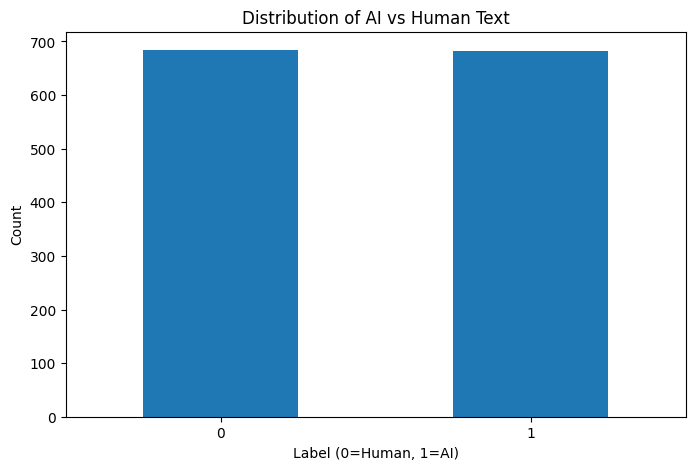

In [9]:
print("="*80)
print("DATASET EXPLORATION")
print("="*80)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

print("\nFirst 3 samples:")
print(df[['text_content', 'label']].head(3))

print("\nLabel distribution:")
print(df['label'].value_counts())

# Visualize label distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of AI vs Human Text')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [10]:
print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Extract features and labels
texts = df['text_content'].values
labels = df['label'].values

# Convert labels to binary if they're strings
if labels.dtype == 'object':
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    print(f"\nLabel mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
else:
    print(f"\nLabels are already numeric: {np.unique(labels)}")

# Split the data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTraining samples: {len(X_train_text)}")
print(f"Testing samples: {len(X_test_text)}")

DATA PREPROCESSING

Labels are already numeric: [0 1]

Training samples: 1093
Testing samples: 274


Tokenisation + sequences+ padding + embeddings

Example:
Sentence → `"I love pizza"`
Tokenizer might map it as:

```
"I"     → 5
"love"  → 23
"pizza" → 11
```

So the sentence becomes:

```
[5, 23, 11]
```


```
["<OOV>"]
```


Example (`max_length = 6`):

```
Original: [5, 23, 11]              →  [5, 23, 11, 0, 0, 0]   (padded)
Original: [9, 4, 6, 2, 8, 5, 10]   →  [9, 4, 6, 2, 8, 5]     (truncated)
```


In [11]:
I love Pizza
[1,0,0]



SyntaxError: invalid syntax (ipython-input-494006285.py, line 1)

```
Word: "love"   → [0.25, 0.80, -0.33]
Word: "hate"   → [-0.20, -0.75, 0.40]
Word: "pizza"  → [0.10, 0.65, 0.55]
```


In [ ]:
love like

## 🎨 **Visual Representation**

```
Word: "love" → Index: 234 → Embedding Vector: [0.2, -0.5, 0.8, ..., 0.3] (128 dimensions)

Before Embedding:                After Embedding:
"I love AI"                      [[0.1, -0.3, 0.5, ...],    <- "I"
     ↓                            [0.2, -0.5, 0.8, ...],    <- "love"
[15, 234, 89]                     [0.7,  0.2, -0.1, ...]]   <- "AI"
(word indices)                    (128-dimensional vectors)
```


# Vocabulary of 10,000 words

"love" = [0, 0, 0, ..., 1, ..., 0, 0] # 10,000 dimensions!

"like" = [0, 0, 1, ..., 0, ..., 0, 0] # Also 10,000 dimensions!


### ✅ **With Embeddings:**

```python
"love" = [0.2, -0.5, 0.8, ..., 0.3]  # Only 128 dimensions!
"like" = [0.21, -0.48, 0.79, ..., 0.31]  # Similar to "love"!
"hate" = [-0.3, 0.6, -0.7, ..., -0.2]  # Opposite direction!
```


In [ ]:
10,000 wors -> [....] 128 size

10000*128

"avengers" -> [0.8, 0.3, 0.7,.....]
"avengers" -> [action, superhero, blockbuster, ...]
"Iron man"


```python
layers.Embedding(input_dim=10000,    # Size of vocabulary
                output_dim=128,       # Size of embedding vector
                input_length=200)     # Max sequence length
```


In [ ]:
here is shivank and he is teaching ...........

king - Man +  Woman = Queen

cosine_similarity("iron man", "avengers")


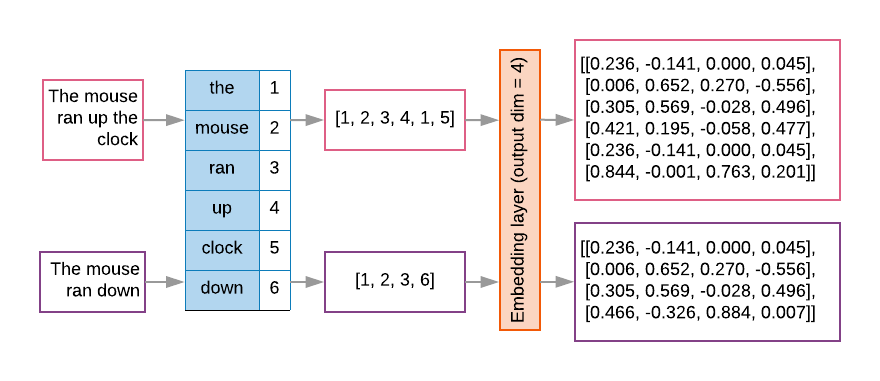


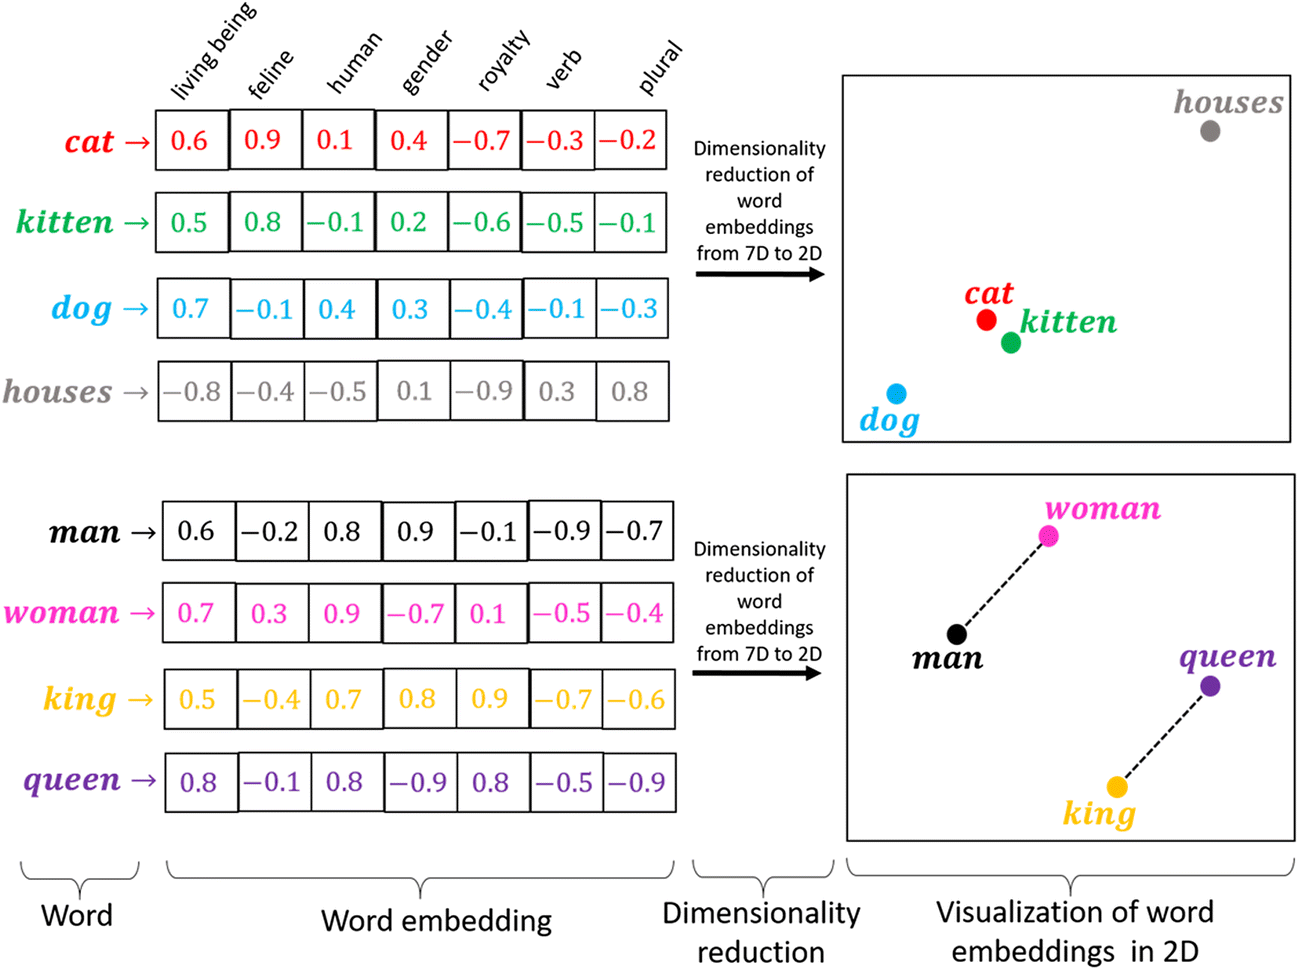


In [ ]:
print("="*80)
print("TEXT VECTORIZATION")
print("="*80)

# Set parameters
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_LENGTH = 200    # Maximum length of sequences

print(f"\nParameters:")
print(f"- Max vocabulary size: {MAX_WORDS}")
print(f"- Max sequence length: {MAX_LENGTH}")

In [ ]:
# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

In [12]:
# Install required packages (if needed)
# !pip install tensorflow scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
df = pd.read_csv('ai_human_content_detection_dataset.csv')

df.head()

,text_content,content_type,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
0,Score each cause. Quality throughout beautiful...,academic_paper,288,1927,54,0.9514,5.33,5.69,0.0280,53.08,7.41,1,0.1041,105.86,0.5531,0.2034,1
1,Board its rock. Job worker break tonight coupl...,essay,253,1719,45,0.9723,5.62,5.80,0.0262,50.32,8.10,6,0.2045,100.29,0.5643,0.4854,1
2,Way debate decision produce. Dream necessary c...,academic_paper,420,2849,75,0.9071,5.60,5.79,0.0263,46.86,7.86,5,0.2308,96.88,0.4979,-0.2369,1
3,Story turn because such during open model. Tha...,creative_writing,196,1310,34,0.9592,5.76,5.69,0.0260,53.80,7.00,2,0.1912,88.79,0.6241,NaN,1
4,Place specific as simply leader fall analysis....,news_article,160,1115,28,0.9688,5.71,5.97,0.0251,44.53,8.29,0,0.1318,26.15,0.2894,NaN,1


DATASET EXPLORATION

Dataset shape: (1367, 17)

Columns: ['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label']

First 3 samples:
                                        text_content  label
0  Score each cause. Quality throughout beautiful...      1
1  Board its rock. Job worker break tonight coupl...      1
2  Way debate decision produce. Dream necessary c...      1

Label distribution:
label
0    684
1    683
Name: count, dtype: int64


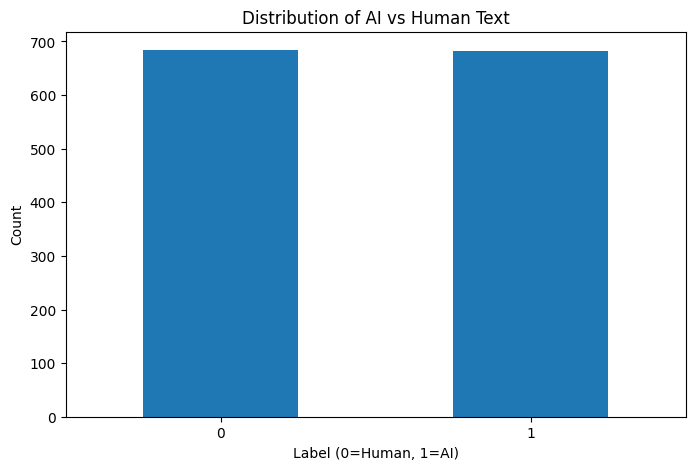

In [14]:
print("="*80)
print("DATASET EXPLORATION")
print("="*80)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

print("\nFirst 3 samples:")
print(df[['text_content', 'label']].head(3))

print("\nLabel distribution:")
print(df['label'].value_counts())

# Visualize label distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of AI vs Human Text')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [15]:
print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Extract features and labels
texts = df['text_content'].values
labels = df['label'].values

# Convert labels to binary if they're strings
if labels.dtype == 'object':
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    print(f"\nLabel mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
else:
    print(f"\nLabels are already numeric: {np.unique(labels)}")

# Split the data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTraining samples: {len(X_train_text)}")
print(f"Testing samples: {len(X_test_text)}")

DATA PREPROCESSING

Labels are already numeric: [0 1]

Training samples: 1093
Testing samples: 274


In [16]:
print("="*80)
print("TEXT VECTORIZATION")
print("="*80)

# Set parameters
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_LENGTH = 200    # Maximum length of sequences

print(f"\nParameters:")
print(f"- Max vocabulary size: {MAX_WORDS}")
print(f"- Max sequence length: {MAX_LENGTH}")

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Padded sequence shape: {X_train_padded.shape}")

# Show example of tokenization
example_text = X_train_text[0][:100]
example_seq = tokenizer.texts_to_sequences([example_text])[0]
print(f"\nExample text: '{example_text}...'")
print(f"Tokenized: {example_seq[:10]}...")

TEXT VECTORIZATION

Parameters:
- Max vocabulary size: 10000
- Max sequence length: 200

Vocabulary size: 972
Padded sequence shape: (1093, 200)

Example text: 'Listen information scene again. As the discussion water popular. Official pretty skin main program m...'
Tokenized: [341, 660, 205, 153, 272, 366, 554, 28, 273, 14]...


Input text -> tokenising -> Embedding -> flatten -> dense -> output

i/p -> (batch_size, seq_length)

o/p-> (..,.., embed_dim)


```
Before Flatten (2D):              After Flatten (1D):
┌─────────────┐
│ [0.1, 0.2]  │ word 1            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
│ [0.3, 0.4]  │ word 2     →      All values in a single row!
│ [0.5, 0.6]  │ word 3
└─────────────┘
Shape: (3, 2)                     Shape: (6,)
```


```python
# Your text after embedding:
embedded_text = [
    [[0.1, 0.2, 0.3],  # Word 1 embedding
     [0.4, 0.5, 0.6],  # Word 2 embedding
     [0.7, 0.8, 0.9]]  # Word 3 embedding
]
# Shape: (1, 3, 3) = (batch, sequence_length, embedding_dim)

# After Flatten:
flattened = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Shape: (1, 9) = (batch, flattened_features)

# Now Dense layer can process it! ✅
```


## 🧮 **The Math Behind Flatten**

```python
Input shape:  (batch_size, 200, 128)
Output shape: (batch_size, 200 × 128)
Output shape: (batch_size, 25,600)

# No parameters to learn! It's just reshaping:
Parameters = 0

Flatten(X) = reshape(X, [batch_size, -1])
where -1 means "figure out this dimension automatically"

# Let's trace through your model:

"I love AI"
    ↓
[15, 234, 89] (tokenized)
    ↓
Embedding (MAX_LENGTH=200, embedding_dim=128)
    ↓
Shape: (200, 128)  # 200 words × 128 features each
    ↓
🔧 FLATTEN HAPPENS HERE 🔧
    ↓
Shape: (25,600)  # 200 × 128 = 25,600 features
    ↓
Dense layer can now process these 25,600 features!
```


Before Flatten (Organized Shelves):
Shelf 1: [Book1, Book2, Book3]
Shelf 2: [Book4, Book5, Book6]
Shelf 3: [Book7, Book8, Book9]

After Flatten (Moving Day):
Box: [Book1, Book2, Book3, Book4, Book5, Book6, Book7, Book8, Book9]

All books in one long box for transport!


In [ ]:
layers.Flatten()
# Pros: Simple, preserves all information
# Cons: Creates very large vectors (25,600 dimensions!)
# Use case: When you want ALL the information

# Global average pooling

layers.GlobalAveragePooling1D()
# Input: (200, 128) → Output: (128)
# Takes average across sequence dimension
# Pros: Much smaller output, less overfitting
# Cons: Loses positional information

# Input: (3 words, 4 features each)
X = [[1, 2, 3, 4],    # Word 1
     [5, 6, 7, 8],    # Word 2
     [9, 10, 11, 12]] # Word 3

# Global Average Pooling:
Output = [(1+5+9)/3, (2+6+10)/3, (3+7+11)/3, (4+8+12)/3]
Output = [5.0, 6.0, 7.0, 8.0]

# Shape: (3, 4) → (4)

In [ ]:
# Input: (3 words, 4 features each)
X = [[1, 2, 3, 4],    # Word 1
     [5, 6, 7, 8],    # Word 2
     [9, 10, 11, 12]] # Word 3

# Global Max Pooling:
Output = [max(1,5,9), max(2,6,10), max(3,7,11), max(4,8,12)]
Output = [9, 10, 11, 12]

# Shape: (3, 4) → (4)


layers.GlobalMaxPooling1D()


In [ ]:
y = f(Wx + b)

Where:
- x: input vector (n dimensions)
- W: weight matrix (m × n dimensions)
- b: bias vector (m dimensions)
- f: activation function
- y: output vector (m dimensions)

In [ ]:
Input: x = [x₁, x₂] = [0.5, 0.3]

Weight Matrix W:
[[w₁₁, w₁₂],    [[0.2, 0.4],
 [w₂₁, w₂₂],  =  [0.1, 0.3],
 [w₃₁, w₃₂]]     [0.5, 0.2]]

Bias: b = [b₁, b₂, b₃] = [0.1, 0.2, 0.3]

Calculation for each neuron:
Neuron 1: (0.5×0.2) + (0.3×0.4) + 0.1 = 0.1 + 0.12 + 0.1 = 0.32
Neuron 2: (0.5×0.1) + (0.3×0.3) + 0.2 = 0.05 + 0.09 + 0.2 = 0.34
Neuron 3: (0.5×0.5) + (0.3×0.2) + 0.3 = 0.25 + 0.06 + 0.3 = 0.61

Output (before activation): [0.32, 0.34, 0.61]

In [ ]:
Total Parameters = (input_size × output_size) + output_size
                   \_____________________/     \________/
                          Weights                Biases

In [ ]:
layers.Dense(64, activation='relu')  # Input: 25,600
Parameters = (25,600 × 64) + 64 = 1,638,464

In [ ]:
def relu(x):
    return x if x > 0 else 0

# Vectorized:
def relu(x):
    return np.maximum(0, x)

In [ ]:
ReLU'(x) = {1  if x > 0
           {0  if x ≤ 0

# Simple gradient = faster backpropagation!

In [ ]:
Input:  [-2, 0.5, -1, 3, -0.1, 2]
Output: [ 0, 0.5,  0, 3,  0,   2]
# 50% sparsity - efficient computation!